In [24]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from torch.distributions import Categorical

from gymenv import Portfolio

import matplotlib.pyplot as plt

In [25]:
%matplotlib inline

In [26]:
state = pd.read_csv('../data/rl/states.csv')
price = pd.read_csv('../data/rl/price.csv')
action = np.load('../data/rl/actions.np.npy')

env = Portfolio(price.values, action, state.values)

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [28]:
class Policy(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(Policy, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.attn1 = nn.Linear(n_observations, n_observations)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        attn = F.sigmoid(self.attn1(x))
        x = torch.mul(x, attn)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return F.softmax(self.layer3(x)), attn

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs, attn = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action), attn

In [29]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.attn1 = nn.Linear(n_observations, n_observations)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        attn = F.sigmoid(self.attn1(x))
        x = torch.mul(x, attn)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x), attn

In [30]:
s_size = env.observation_space.shape[0]
a_size = env.action_space.n
class A2C(nn.Module):
    def __init__(self):
        super(A2C, self).__init__()
        self.affine1 = nn.Linear(s_size, 128)
        self.attn1 = nn.Linear(s_size, s_size)

        self.ac1 = nn.Linear(128, 128)
        self.acrel = nn.ReLU()
        self.action_head = nn.Linear(128, a_size)

        self.cr1 = nn.Linear(128, 128)
        self.crrel = nn.ReLU()
        self.value_head = nn.Linear(128, 1)

        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        attn = F.sigmoid(self.attn1(x))
        x = torch.mul(x, attn)
        x = F.relu(self.affine1(x))

        y = self.ac1(x)
        y = self.acrel(y)
        action_prob = F.softmax(self.action_head(y), dim=-1)

        z = self.cr1(x)
        z = self.crrel(z)
        state_values = self.value_head(z)

        return action_prob, state_values, attn


In [31]:
random_actions = [np.random.randint(low=0, high=500) for i in range(3967)]

In [32]:
np.random.seed(2024)
torch.cuda.manual_seed(2024)
torch.manual_seed(2024)


policy = Policy(env.observation_space.shape[0], env.action_space.n)
policy.load_state_dict(torch.load('../reinforce/reinforced-policy2.pt'))

actions = []
log_probs = []
attentions = []
rew = []
states = []

state, info = env.reset()
done = info['done']
while not done:
    with torch.no_grad():
        action, lprob, attn = policy.act(state)
    states.append(state)
    state, reward, done, _, _ = env.step({'action': action, 'attn': attn})
    rew.append(reward)
    attentions.append(attn)
    log_probs.append(lprob)
    actions.append(action)
    
print(f'Average reinforce reward: {sum(rew)/len(rew)}')

pval = price.values

returns = []
for i in range(1, len(price) - 1):
    returns.append((pval[i] - pval[i - 1]) / pval[i - 1])
    
state_mat = pd.read_csv('../data/rl/states.csv')
action_mat = np.load('../data/rl/actions.np.npy')

portfolio_val = [np.dot(action_mat[i], pval[ind + 2]) for ind, i in enumerate(actions)]
random_actions = [np.random.randint(low=0, high=500) for i in range(3967)]
random_reward = []

print(f'Net returns from reinforce: {(portfolio_val[-1] - portfolio_val[0]) / portfolio_val[0] * 100}%')

rportfolio_val = [np.dot(action_mat[i], pval[ind + 2]) for ind, i in enumerate(random_actions)]

state, info = env.reset()
done = info['done']
index = 0
while not done:
    state, reward, done, _, _ = env.step({'action': random_actions[index], 'attn': torch.ones(64) * 0.5})
    random_reward.append(reward)
    index += 1
    
print(f'Average random reward: {sum(random_reward)/len(random_reward)}')
print(f'Net returns from random walk: {(rportfolio_val[-1] - rportfolio_val[0]) / rportfolio_val[0]*100}%')

/home/sharchit/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/tmp/ipykernel_9212/1622286783.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.layer3(x)), attn


Average reinforce reward: 90.706757018114
Net returns from reinforce: 2608.330873440061%
Average random reward: 84.42755206201366
Net returns from random walk: 1031.462173787019%


In [33]:
np.random.seed(2024)
torch.cuda.manual_seed(2024)
torch.manual_seed(2024)


model = DQN(env.observation_space.shape[0], env.action_space.n)
model.load_state_dict(torch.load('../dqn/target_net2.pt'))

dactions = []
dattentions = []
drew = []
dstates = []

state, info = env.reset()
done = info['done']
while not done:
    with torch.no_grad():
        action, attn = model(torch.Tensor(state).to(device))
        action = action.unsqueeze(0).max(1).indices.view(1, 1)
    dstates.append(state)
    state, reward, done, _, _ = env.step({'action': action, 'attn': attn})
    drew.append(reward)
    dattentions.append(attn)
    dactions.append(action)
    
print(f'Average dqn reward: {sum(drew)/len(drew)}')

pval = price.values

dreturns = []
for i in range(1, len(price) - 1):
    dreturns.append((pval[i] - pval[i - 1]) / pval[i - 1])
    
state_mat = pd.read_csv('../data/rl/states.csv')
action_mat = np.load('../data/rl/actions.np.npy')

dportfolio_val = [np.dot(action_mat[i], pval[ind + 2]) for ind, i in enumerate(dactions)]

print(f'Net returns from dqn: {(dportfolio_val[-1] - dportfolio_val[0]) / dportfolio_val[0] * 100}%')
    
# print(f'Average random reward: {sum(random_reward)/len(random_reward)}')
# print(f'Net returns from random walk: {(rportfolio_val[-1] - rportfolio_val[0]) / rportfolio_val[0]*100}%')

/home/sharchit/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Average dqn reward: 88.7974699808672
Net returns from dqn: 1037.8399717259822%


In [34]:
np.random.seed(2024)
torch.cuda.manual_seed(2024)
torch.manual_seed(2024)

model = A2C()
model.load_state_dict(torch.load('a2c-policy2.pt'))

aactions = []
aattentions = []
arew = []
astates = []

state, info = env.reset()
done = info['done']
while not done:
    with torch.no_grad():
        action_prob, state_val, attn = model(torch.Tensor(state).to(device))
        m = Categorical(action_prob)
        action = m.sample()

    astates.append(state)
    state, reward, done, _, _ = env.step({'action': action, 'attn': attn})
    arew.append(reward)
    aattentions.append(attn)
    aactions.append(action)
    
print(f'Average a2c reward: {sum(arew)/len(arew)}')

pval = price.values

areturns = []
for i in range(1, len(price) - 1):
    areturns.append((pval[i] - pval[i - 1]) / pval[i - 1])
    
state_mat = pd.read_csv('../data/rl/states.csv')
action_mat = np.load('../data/rl/actions.np.npy')

aportfolio_val = [np.dot(action_mat[i], pval[ind + 2]) for ind, i in enumerate(aactions)]

print(f'Net returns from a2c: {(aportfolio_val[-1] - aportfolio_val[0]) / aportfolio_val[0] * 100}%')

/home/sharchit/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Average a2c reward: 79.82943209558668
Net returns from dqn: 896.067915119651%


In [35]:
nifty = pd.read_csv('../data/archive/NIFTY 50_Data.csv')

In [36]:
nifty_val = list(nifty.Close)

In [37]:
print(f'Average Nifty Return: {(nifty_val[0] - nifty_val[-1]) / nifty_val[-1] * 100}%')

Average Nifty Return: 1020.0445923878908%


In [38]:
equalp = [np.dot(np.ones(10)/10, pval[ind + 2]) for ind, i in enumerate(dactions)]
print(f'Average equal dist Return: {(equalp[-1] - equalp[0]) / equalp[0] * 100}%')

Average equal dist Return: 1052.4532157225756%


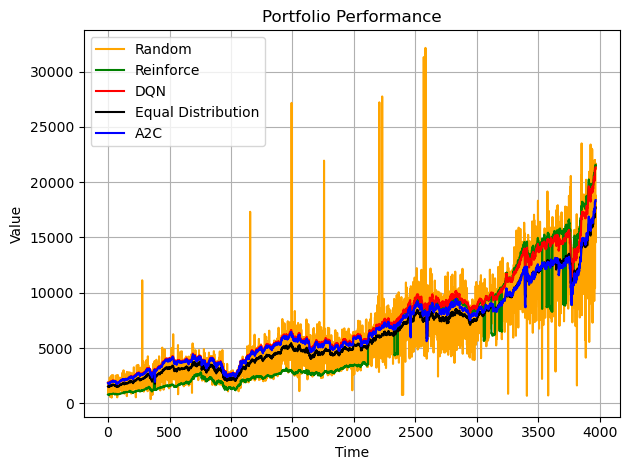

In [39]:
plt.plot(rportfolio_val, color='orange', label='Random')
plt.plot(portfolio_val, color='green', label='Reinforce')
plt.plot(dportfolio_val, color='red', label='DQN')
plt.plot(equalp, color='black', label='Equal Distribution')
plt.plot(aportfolio_val, color='blue', label='A2C')

plt.xlabel('Time')  
plt.ylabel('Value')  
plt.title('Portfolio Performance')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

In [40]:
# TODO: Retrain reinforce

# Evaluating Attention

In [41]:
import seaborn as sns

In [42]:
def see_attention_dqn(idx):
    dattention_transposed = dattentions[idx].unsqueeze(dim=1).T

    plt.figure(figsize=(24, 0.5))
    heatmap = sns.heatmap(dattention_transposed, annot=True, fmt=".1f", xticklabels=state_mat.columns, cbar=False)

    for _, spine in heatmap.spines.items():
        spine.set_visible(True) 

    plt.title("Attention Heatmap")
    plt.xlabel("Attention")
    plt.ylabel("Input Feature")
    plt.tight_layout() 
    plt.show()

In [43]:
print(dattentions[0].shape, attentions[0].shape)

torch.Size([64]) torch.Size([1, 64])


In [44]:
def see_attention_rei(idx):
    dattention_transposed = attentions[idx].squeeze(dim=0)
    dattention_transposed = dattentions[idx].unsqueeze(dim=1).T
    plt.figure(figsize=(24, 0.5))
    heatmap = sns.heatmap(dattention_transposed, annot=True, fmt=".1f", xticklabels=state_mat.columns, cbar=False)

    for _, spine in heatmap.spines.items():
        spine.set_visible(True) 

    plt.title("Attention Heatmap")
    plt.xlabel("Attention")
    plt.ylabel("Input Feature")
    plt.tight_layout() 
    plt.show()

/tmp/ipykernel_9212/2842981553.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


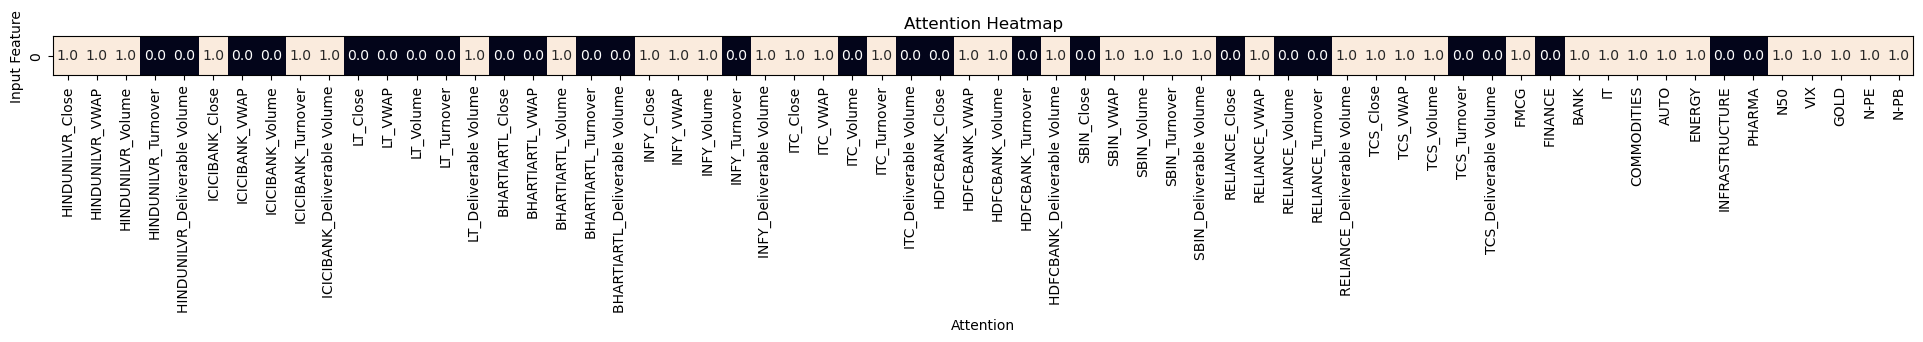

In [45]:
see_attention_dqn(0)

/tmp/ipykernel_9212/2842981553.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


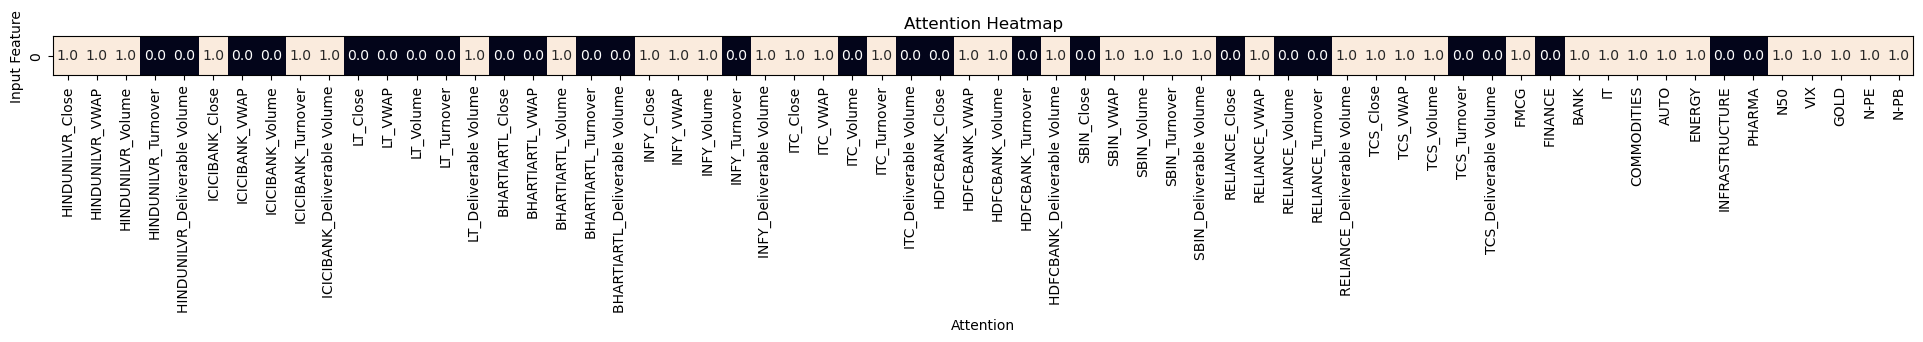

In [46]:
see_attention_dqn(2000)

/tmp/ipykernel_9212/1271341412.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


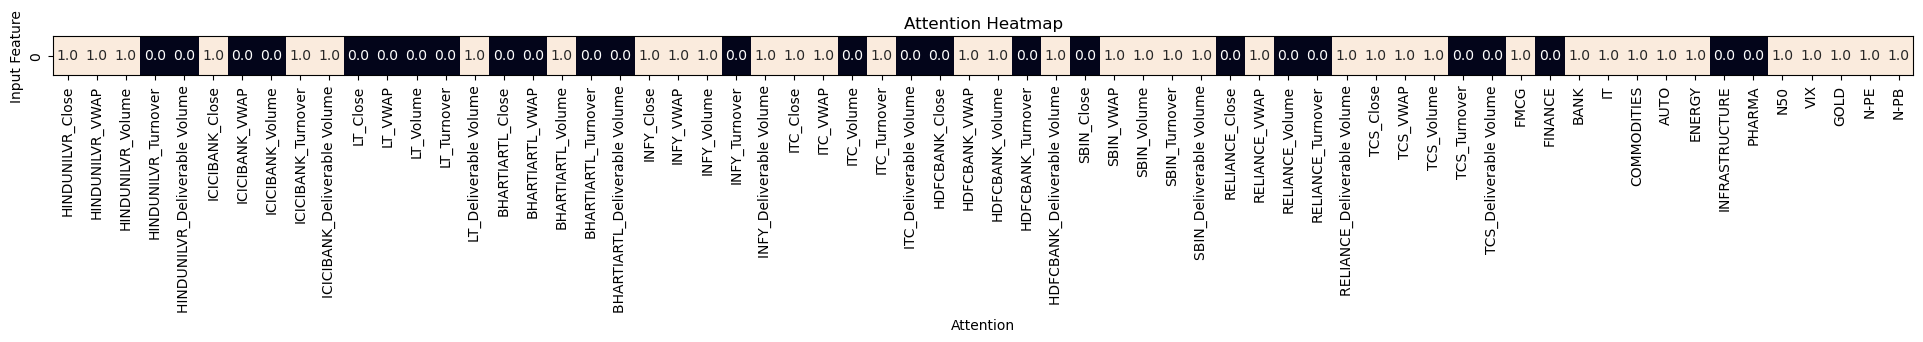

In [47]:
see_attention_rei(1000)

In [48]:
from tqdm import trange

In [49]:
mx = -1000
vi, vj = -1, -1
for i in trange(0, len(dattentions) - 1):
    for j in range(i + 1, len(dattentions)):
        calc = torch.abs(dattentions[i] - dattentions[j]).mean().item() 
        if calc > mx:
            mx, vi, vj = calc, i, j
print(mx)
print(vi, vj)

 29%|██▉       | 1144/3966 [00:41<01:43, 27.25it/s]


KeyboardInterrupt: 

/tmp/ipykernel_3585/2842981553.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


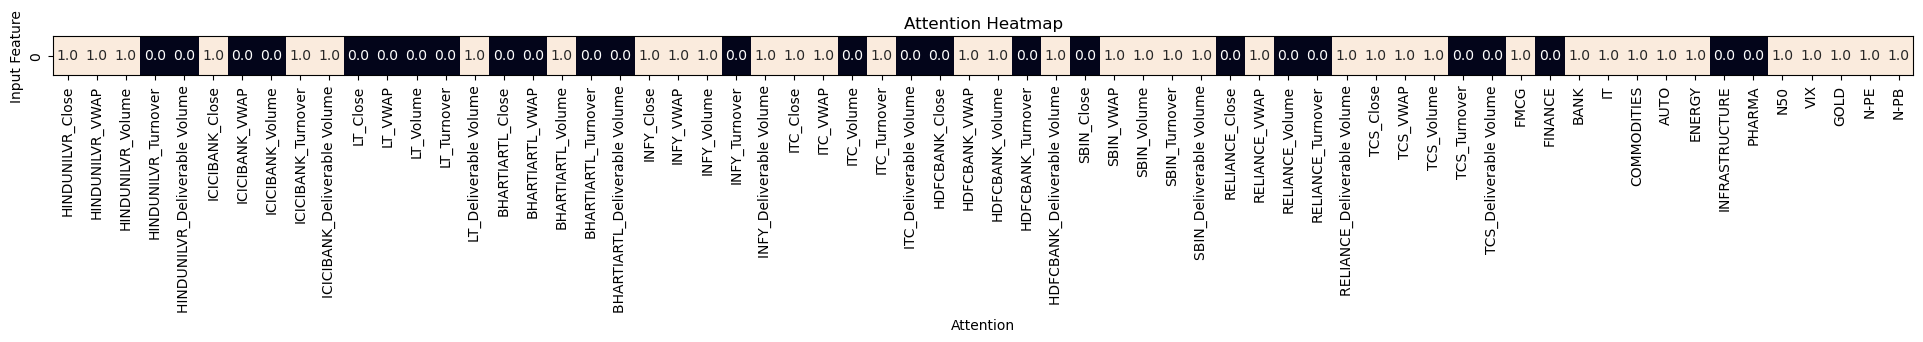

In [ ]:
see_attention_dqn(vi)

/tmp/ipykernel_3585/2842981553.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


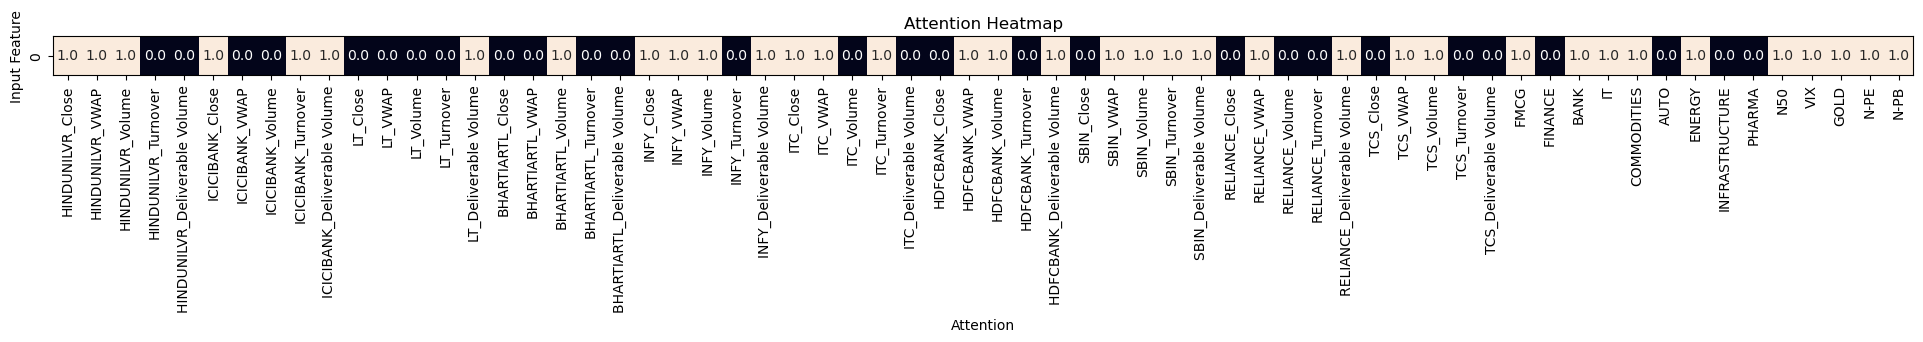

In [ ]:
see_attention_dqn(vj)

In [ ]:
mx = -1000
vi, vj = -1, -1
for i in trange(0, len(attentions) - 1):
    for j in range(i + 1, len(attentions)):
        calc = torch.abs(attentions[i] - attentions[j]).mean().item() 
        if calc > mx:
            mx, vi, vj = calc, i, j
print(mx)
print(vi, vj)

100%|██████████| 3966/3966 [01:34<00:00, 41.90it/s] 

0.28125
705 3786


/tmp/ipykernel_3585/1271341412.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


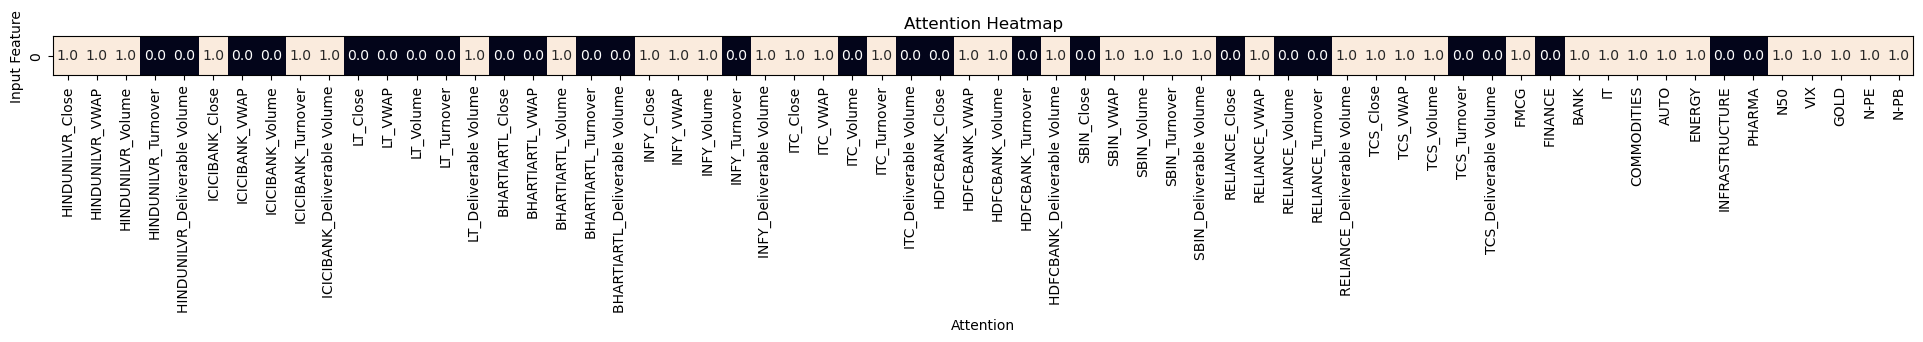

In [ ]:
see_attention_rei(vi)

/tmp/ipykernel_3585/1271341412.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


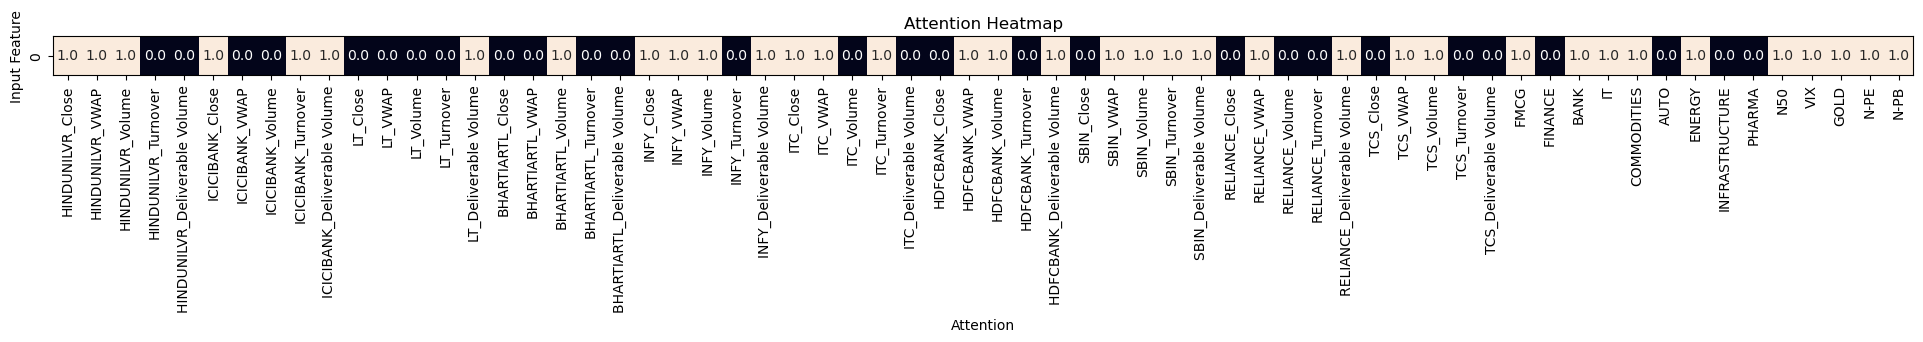

In [ ]:
see_attention_rei(vj)